In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
from mpl_toolkits.mplot3d import Axes3D

# Carichiamo il file Excel
df = pd.read_excel('FacoDMEK.xlsx', sheet_name='Data')

# Vediamo cosa c'è dentro
print(f"Numero totale di pazienti: {len(df)}")
print(f"\nNumero di colonne: {len(df.columns)}")

Numero totale di pazienti: 96

Numero di colonne: 29


In [2]:
# Calcolo del K medio
df['K_avg'] = (df['Bio-Ks'] + df['Bio-Kf']) / 2

In [3]:
def calcola_refrazione_srkt(AL, K_avg, IOL_power, A_constant):
    """
    Formula SRK/T ORIGINALE - senza correzione per imaginary ACD
    Restituirà NaN per alcuni pazienti
    """
    
    # COSTANTI
    na = 1.336   
    nc = 1.333   
    ncm1 = 0.333 
    V = 12       
    
    # STEP 1: Raggio corneale
    r = 337.5 / K_avg
    
    # STEP 2: Lunghezza assiale corretta
    if AL <= 24.2:
        LCOR = AL  
    else:
        LCOR = 3.446 + 1.716 * AL - 0.0237 * AL * AL  
    
    # STEP 3: Larghezza corneale
    Cw = -5.41 + 0.58412 * LCOR + 0.098 * K_avg
    
    # STEP 4: Altezza corneale (SENZA correzione)
    H = r - np.sqrt(r * r - (Cw * Cw / 4))  # Darà NaN se negativo
    
    # STEP 5-8: Resto del calcolo
    ACD_const = 0.62467 * A_constant - 68.747
    offset = ACD_const - 3.336
    ACD_est = H + offset
    
    RETHICK = 0.65696 - 0.02029 * AL
    LOPT = AL + RETHICK
    
    numeratore = (1000 * na * (na * r - ncm1 * LOPT) - 
                  IOL_power * (LOPT - ACD_est) * (na * r - ncm1 * ACD_est))
    
    denominatore = (na * (V * (na * r - ncm1 * LOPT) + LOPT * r) - 
                    0.001 * IOL_power * (LOPT - ACD_est) * 
                    (V * (na * r - ncm1 * ACD_est) + ACD_est * r))
    
    return numeratore / denominatore

# Applica la formula originale
df['Refrazione_Prevista_SRKT'] = df.apply(
    lambda row: calcola_refrazione_srkt(
        AL=row['Bio-AL'], 
        K_avg=row['K_avg'], 
        IOL_power=row['IOL Power'], 
        A_constant=row['A-Constant']
    ), 
    axis=1
)

# Calcola errori SOLO per i pazienti validi (no NaN)
validi = df['Refrazione_Prevista_SRKT'].notna()
df_validi = df[validi].copy()

df_validi['Errore_Predizione'] = df_validi['PostOP Spherical Equivalent'] - df_validi['Refrazione_Prevista_SRKT']
df_validi['Errore_Assoluto'] = abs(df_validi['Errore_Predizione'])

# Risultati
print(f"RISULTATI SRK/T (solo pazienti validi):")
print("="*50)
print(f"Pazienti validi: {len(df_validi)} su {len(df)} totali")
print(f"Pazienti esclusi (NaN): {len(df) - len(df_validi)}")
print(f"\nMAE (Mean Absolute Error): {df_validi['Errore_Assoluto'].mean():.3f} D")
print(f"Errore medio: {df_validi['Errore_Predizione'].mean():.3f} D")
print(f"Deviazione standard: {df_validi['Errore_Predizione'].std():.3f} D")

RISULTATI SRK/T (solo pazienti validi):
Pazienti validi: 67 su 96 totali
Pazienti esclusi (NaN): 29

MAE (Mean Absolute Error): 1.274 D
Errore medio: 0.165 D
Deviazione standard: 1.762 D


C:\Users\offic\AppData\Local\Temp\ipykernel_8824\879622920.py:26: RuntimeWarning: invalid value encountered in sqrt
  H = r - np.sqrt(r * r - (Cw * Cw / 4))  # Darà NaN se negativo


Funzione SRK/T parametrica e funzione obiettivo

In [4]:
def calcola_refrazione_srkt_param(AL, K_avg, IOL_power, A_constant, na=1.336, nc=1.333, k_index=1.3375):
    """
    Formula SRK/T con parametri ottimizzabili
    """
    # COSTANTE VERTEX DISTANCE
    V = 12
    
    # Calcola ncm1 dal parametro nc
    ncm1 = nc - 1
    
    # STEP 1: Raggio corneale usando k_index parametrico
    r = (k_index - 1) * 1000 / K_avg
    
    # STEP 2: Lunghezza assiale corretta
    if AL <= 24.2:
        LCOR = AL  
    else:
        LCOR = 3.446 + 1.716 * AL - 0.0237 * AL * AL  
    
    # STEP 3: Larghezza corneale
    Cw = -5.41 + 0.58412 * LCOR + 0.098 * K_avg
    
    # STEP 4: Altezza corneale
    term = r * r - (Cw * Cw / 4)
    if term < 0:
        return np.nan
    H = r - np.sqrt(term)
    
    # STEP 5-8: Resto del calcolo
    ACD_const = 0.62467 * A_constant - 68.747
    offset = ACD_const - 3.336
    ACD_est = H + offset
    
    RETHICK = 0.65696 - 0.02029 * AL
    LOPT = AL + RETHICK
    
    numeratore = (1000 * na * (na * r - ncm1 * LOPT) - 
                  IOL_power * (LOPT - ACD_est) * (na * r - ncm1 * ACD_est))
    
    denominatore = (na * (V * (na * r - ncm1 * LOPT) + LOPT * r) - 
                    0.001 * IOL_power * (LOPT - ACD_est) * 
                    (V * (na * r - ncm1 * ACD_est) + ACD_est * r))
    
    return numeratore / denominatore

# Funzione obiettivo per ottimizzazione
def calcola_mae(params):
    na, nc, k_index = params
    
    predictions = df.apply(
        lambda row: calcola_refrazione_srkt_param(
            AL=row['Bio-AL'], 
            K_avg=row['K_avg'], 
            IOL_power=row['IOL Power'], 
            A_constant=row['A-Constant'],
            na=na,
            nc=nc,
            k_index=k_index
        ), 
        axis=1
    )
    
    # Calcola MAE solo per predizioni valide
    validi = predictions.notna()
    if validi.sum() == 0:
        return 999  # Penalità alta se tutti NaN
    
    errori = abs(df.loc[validi, 'PostOP Spherical Equivalent'] - predictions[validi])
    return errori.mean()

Refractive Index & Keratometric Index Variables

In [5]:
# ===== CONFIGURAZIONE PARAMETRI DI OTTIMIZZAZIONE =====

# na FISSO (non lo ottimizziamo)
NA_FISSO = 1.336

# Range per nc (indice rifrazione corneale)
NC_MIN = 1.325
NC_MAX = 1.345

# Range per k_index (indice cheratometrico)
K_INDEX_MIN = 1.325
K_INDEX_MAX = 1.345

# Numero di punti per grid search
GRID_POINTS = 15

# Parametri per Differential Evolution
DE_MAXITER = 150
DE_POPSIZE = 20

# Valori standard di riferimento
STANDARD_NA = 1.336
STANDARD_NC = 1.333
STANDARD_K_INDEX = 1.3375

print("CONFIGURAZIONE CARICATA:")
print(f"na FISSO: {NA_FISSO}")
print(f"Range nc: [{NC_MIN}, {NC_MAX}]")
print(f"Range k_index: [{K_INDEX_MIN}, {K_INDEX_MAX}]")
print(f"Grid points: {GRID_POINTS}x{GRID_POINTS}")

CONFIGURAZIONE CARICATA:
na FISSO: 1.336
Range nc: [1.325, 1.345]
Range k_index: [1.325, 1.345]
Grid points: 15x15


Grid Search

Esecuzione Grid Search per nc e k_index...
Progresso: 100%

RISULTATI GRID SEARCH:
na (fisso): 1.3360
Miglior nc: 1.3250
Miglior k_index: 1.3293
MAE: 1.1277 D


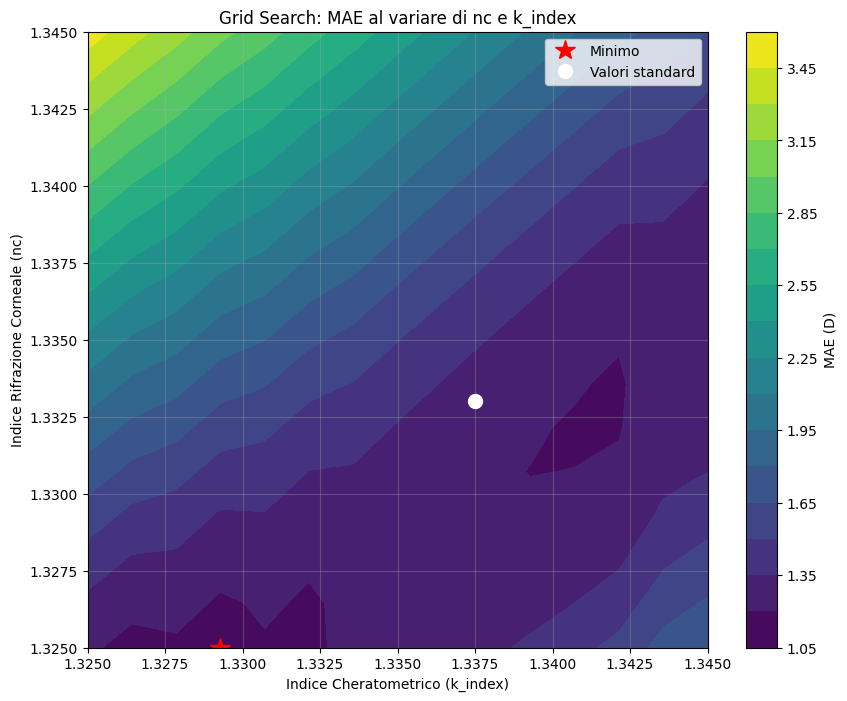

In [6]:
# Grid search per nc e k_index
nc_range = np.linspace(NC_MIN, NC_MAX, GRID_POINTS)
k_index_range = np.linspace(K_INDEX_MIN, K_INDEX_MAX, GRID_POINTS)

print("Esecuzione Grid Search per nc e k_index...")
risultati_grid = np.zeros((len(nc_range), len(k_index_range)))

for i, nc in enumerate(nc_range):
    for j, k_index in enumerate(k_index_range):
        mae = calcola_mae([NA_FISSO, nc, k_index])
        risultati_grid[i, j] = mae
    print(f"Progresso: {(i+1)/len(nc_range)*100:.0f}%", end='\r')

# Trova minimo
min_idx = np.unravel_index(risultati_grid.argmin(), risultati_grid.shape)
best_nc_grid = nc_range[min_idx[0]]
best_k_grid = k_index_range[min_idx[1]]
best_mae_grid = risultati_grid[min_idx]

print(f"\n\nRISULTATI GRID SEARCH:")
print(f"na (fisso): {NA_FISSO:.4f}")
print(f"Miglior nc: {best_nc_grid:.4f}")
print(f"Miglior k_index: {best_k_grid:.4f}")
print(f"MAE: {best_mae_grid:.4f} D")

# Visualizzazione
plt.figure(figsize=(10, 8))
X, Y = np.meshgrid(k_index_range, nc_range)
contour = plt.contourf(X, Y, risultati_grid, levels=20, cmap='viridis')
plt.colorbar(contour, label='MAE (D)')
plt.plot(best_k_grid, best_nc_grid, 'r*', markersize=15, label='Minimo')
plt.plot(STANDARD_K_INDEX, STANDARD_NC, 'wo', markersize=10, label='Valori standard')
plt.xlabel('Indice Cheratometrico (k_index)')
plt.ylabel('Indice Rifrazione Corneale (nc)')
plt.title('Grid Search: MAE al variare di nc e k_index')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Differential Evolution

In [7]:
from scipy.optimize import differential_evolution

# Funzione obiettivo modificata per 2 parametri
def calcola_mae_2param(params):
    nc, k_index = params
    return calcola_mae([NA_FISSO, nc, k_index])

# Bounds solo per nc e k_index
bounds = [
    (NC_MIN, NC_MAX),           # nc
    (K_INDEX_MIN, K_INDEX_MAX)  # k_index
]

print("Esecuzione Differential Evolution per nc e k_index...")
print("Questo potrebbe richiedere qualche minuto...\n")

risultato_de = differential_evolution(
    calcola_mae_2param,
    bounds,
    seed=42,
    maxiter=DE_MAXITER,
    popsize=DE_POPSIZE,
    disp=True,
    polish=True
)

print(f"\n\nRISULTATI DIFFERENTIAL EVOLUTION:")
print(f"na (fisso): {NA_FISSO:.6f}")
print(f"nc ottimale: {risultato_de.x[0]:.6f}") 
print(f"k_index ottimale: {risultato_de.x[1]:.6f}")
print(f"MAE ottimale: {risultato_de.fun:.4f} D")

# Confronto con valori standard
mae_standard = calcola_mae([NA_FISSO, STANDARD_NC, STANDARD_K_INDEX])
print(f"\nConfronti:")
print(f"MAE con valori standard: {mae_standard:.4f} D")
print(f"Miglioramento: {mae_standard - risultato_de.fun:.4f} D ({(mae_standard - risultato_de.fun)/mae_standard*100:.1f}%)")

Esecuzione Differential Evolution per nc e k_index...
Questo potrebbe richiedere qualche minuto...

differential_evolution step 1: f(x)= 1.1223273019195439
differential_evolution step 2: f(x)= 1.1223273019195439
differential_evolution step 3: f(x)= 1.1223273019195439
differential_evolution step 4: f(x)= 1.1199810608669092
differential_evolution step 5: f(x)= 1.1199810608669092
differential_evolution step 6: f(x)= 1.1199810608669092
differential_evolution step 7: f(x)= 1.1199810608669092
differential_evolution step 8: f(x)= 1.1195472570811458
differential_evolution step 9: f(x)= 1.1195472570811458
differential_evolution step 10: f(x)= 1.1092103099968569
differential_evolution step 11: f(x)= 1.1092103099968569
differential_evolution step 12: f(x)= 1.1092103099968569
differential_evolution step 13: f(x)= 1.1082336876803347
differential_evolution step 14: f(x)= 1.1082336876803347
differential_evolution step 15: f(x)= 1.1082336876803347
differential_evolution step 16: f(x)= 1.10823368768033

Calcolo MAE con Valori Ottimizzati

In [8]:
# Usa i valori ottimizzati da Differential Evolution
nc_ottimizzato = risultato_de.x[0]
k_index_ottimizzato = risultato_de.x[1]

print("CONFRONTO RISULTATI")
print("="*60)

# Calcola predizioni con valori STANDARD
df['Pred_Standard'] = df.apply(
    lambda row: calcola_refrazione_srkt_param(
        AL=row['Bio-AL'], 
        K_avg=row['K_avg'], 
        IOL_power=row['IOL Power'], 
        A_constant=row['A-Constant'],
        na=NA_FISSO,         # fisso
        nc=STANDARD_NC,      # standard
        k_index=STANDARD_K_INDEX  # standard
    ), 
    axis=1
)

# Calcola predizioni con valori OTTIMIZZATI
df['Pred_Ottimizzata'] = df.apply(
    lambda row: calcola_refrazione_srkt_param(
        AL=row['Bio-AL'], 
        K_avg=row['K_avg'], 
        IOL_power=row['IOL Power'], 
        A_constant=row['A-Constant'],
        na=NA_FISSO,              # fisso
        nc=nc_ottimizzato,        # ottimizzato
        k_index=k_index_ottimizzato  # ottimizzato
    ), 
    axis=1
)

# Calcola errori per STANDARD
validi_std = df['Pred_Standard'].notna()
df_validi_std = df[validi_std].copy()
df_validi_std['Errore'] = df_validi_std['PostOP Spherical Equivalent'] - df_validi_std['Pred_Standard']
df_validi_std['Errore_Assoluto'] = abs(df_validi_std['Errore'])

mae_standard = df_validi_std['Errore_Assoluto'].mean()
me_standard = df_validi_std['Errore'].mean()
std_standard = df_validi_std['Errore'].std()

# Calcola errori per OTTIMIZZATO
validi_opt = df['Pred_Ottimizzata'].notna()
df_validi_opt = df[validi_opt].copy()
df_validi_opt['Errore'] = df_validi_opt['PostOP Spherical Equivalent'] - df_validi_opt['Pred_Ottimizzata']
df_validi_opt['Errore_Assoluto'] = abs(df_validi_opt['Errore'])

mae_ottimizzato = df_validi_opt['Errore_Assoluto'].mean()
me_ottimizzato = df_validi_opt['Errore'].mean()
std_ottimizzato = df_validi_opt['Errore'].std()

# Stampa risultati
print("\nFORMULA STANDARD:")
print(f"  na = {NA_FISSO}, nc = {STANDARD_NC}, k_index = {STANDARD_K_INDEX}")
print(f"  Pazienti validi: {validi_std.sum()}/{len(df)}")
print(f"  MAE: {mae_standard:.4f} D")
print(f"  ME:  {me_standard:+.4f} D")
print(f"  SD:  {std_standard:.4f} D")

print("\nFORMULA OTTIMIZZATA:")
print(f"  na = {NA_FISSO:.6f} (fisso)")
print(f"  nc = {nc_ottimizzato:.6f} (ottimizzato)")
print(f"  k_index = {k_index_ottimizzato:.6f} (ottimizzato)")
print(f"  Pazienti validi: {validi_opt.sum()}/{len(df)}")
print(f"  MAE: {mae_ottimizzato:.4f} D")
print(f"  ME:  {me_ottimizzato:+.4f} D")
print(f"  SD:  {std_ottimizzato:.4f} D")

print("\nMIGLIORAMENTO:")
print(f"  Riduzione MAE: {mae_standard - mae_ottimizzato:.4f} D ({(mae_standard - mae_ottimizzato)/mae_standard*100:.1f}%)")
print(f"  Cambiamento ME: {me_standard - me_ottimizzato:.4f} D")

# Percentuali entro range di errore
print("\nACCURATEZZA OTTIMIZZATA:")
within_025 = (df_validi_opt['Errore_Assoluto'] <= 0.25).sum() / len(df_validi_opt) * 100
within_050 = (df_validi_opt['Errore_Assoluto'] <= 0.50).sum() / len(df_validi_opt) * 100
within_075 = (df_validi_opt['Errore_Assoluto'] <= 0.75).sum() / len(df_validi_opt) * 100
within_100 = (df_validi_opt['Errore_Assoluto'] <= 1.00).sum() / len(df_validi_opt) * 100

print(f"  Entro ±0.25D: {within_025:.1f}%")
print(f"  Entro ±0.50D: {within_050:.1f}%")
print(f"  Entro ±0.75D: {within_075:.1f}%")
print(f"  Entro ±1.00D: {within_100:.1f}%")

CONFRONTO RISULTATI

FORMULA STANDARD:
  na = 1.336, nc = 1.333, k_index = 1.3375
  Pazienti validi: 67/96
  MAE: 1.2738 D
  ME:  +0.1651 D
  SD:  1.7623 D

FORMULA OTTIMIZZATA:
  na = 1.336000 (fisso)
  nc = 1.325009 (ottimizzato)
  k_index = 1.327608 (ottimizzato)
  Pazienti validi: 64/96
  MAE: 1.1064 D
  ME:  +0.3881 D
  SD:  1.3952 D

MIGLIORAMENTO:
  Riduzione MAE: 0.1674 D (13.1%)
  Cambiamento ME: -0.2230 D

ACCURATEZZA OTTIMIZZATA:
  Entro ±0.25D: 10.9%
  Entro ±0.50D: 28.1%
  Entro ±0.75D: 40.6%
  Entro ±1.00D: 56.2%
